## EasyVisa Project

Objecive of the project- In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired the firm EasyVisa for data-driven solutions. You as a data scientist at EasyVisa have to analyze the data provided and, with the help of a classification model:

Facilitate the process of visa approvals.
Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status.

## Data description

The data contains the different attributes of the employee and the employer. The detailed data dictionary is given below.

case_id: ID of each visa application
continent: Information of continent the employee
education_of_employee: Information of education of the employee
has_job_experience: Does the employee has any job experience? Y= Yes; N = No
requires_job_training: Does the employee require any job training? Y = Yes; N = No
no_of_employees: Number of employees in the employer's company
yr_of_estab: Year in which the employer's company was established
region_of_employment: Information of foreign worker's intended region of employment in the US.
prevailing_wage: Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment.
unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
full_time_position: Is the position of work full-time? Y = Full-Time Position; N = Part-Time Position
case_status: Flag indicating if the Visa was certified or denied

In [1]:
#Lets start by importing all the libraries

In [2]:
!pip install xgboost

In [3]:
#libraries to read and manipulate data
import numpy as np
import pandas as pd

#libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns

#libraries for model building and tuning
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier,RandomForestClassifier, 
                              GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier)
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#libraries for metrics and statistics
from sklearn import metrics
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
#loading the dataset

In [5]:
visa=pd.read_csv('EasyVisa.csv')

In [6]:
#Lets have a look at the dataset provided

In [7]:
visa

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified
...,...,...,...,...,...,...,...,...,...,...,...,...
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601,2008,South,77092.5700,Year,Y,Certified
25476,EZYV25477,Asia,High School,Y,N,3274,2006,Northeast,279174.7900,Year,Y,Certified
25477,EZYV25478,Asia,Master's,Y,N,1121,1910,South,146298.8500,Year,N,Certified
25478,EZYV25479,Asia,Master's,Y,Y,1918,1887,West,86154.7700,Year,Y,Certified


In [8]:
#Lets make a copy of this dataset
df=visa.copy()

In [9]:
# function to create labeled barplots
def labeled_barplot(data, feature, feature_2, order, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    feature_2: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))
        
    ax = sns.countplot(
        data=data,
        x=feature,
        palette='viridis',
        order=order,
        hue=feature_2,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=9,
            xytext=(0, 5),
            textcoords="offset points"
        )  # annotate the percentage

    plt.show()  # show the plot

In [10]:
# function to plot a boxplot and a histogram along the same scale
def histogram_boxplot(data, feature, figsize=(16, 6), kde=False, bins=None, hue=None):
    """
    Combines boxplot and histogram

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (16,6))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True,
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter",
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [11]:
# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5), cmap='viridis')
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

## Data Overview

In [12]:
#lets see the first five rows of our data
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [13]:
df.tail()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601,2008,South,77092.57,Year,Y,Certified
25476,EZYV25477,Asia,High School,Y,N,3274,2006,Northeast,279174.79,Year,Y,Certified
25477,EZYV25478,Asia,Master's,Y,N,1121,1910,South,146298.85,Year,N,Certified
25478,EZYV25479,Asia,Master's,Y,Y,1918,1887,West,86154.77,Year,Y,Certified
25479,EZYV25480,Asia,Bachelor's,Y,N,3195,1960,Midwest,70876.91,Year,Y,Certified


In [14]:
# print shape of dataset
df.shape

(25480, 12)

In [15]:
#Lets see the info for the dataset now
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


In [16]:
#Data does not have any missing values

In [17]:
#Lets take a look if there are any duplicate values in the data
df.duplicated().value_counts()

False    25480
dtype: int64

Data does not have any duplicate values. There are 1 column with dytpe as float, 2 as integer and 9 as objects

In [18]:
#It might also be a good idea to convert the object datatype in the category type.
for col in df.columns[df.dtypes=='object']:
    df[col] = df[col].astype('category')

In [19]:
#Case_id is a randomly assigned by INA for each case, which should not provide any material information for model building.Hence, we will drop the case_id column
df=df.drop('case_id',axis=1)

In [20]:
#Lets confirm our conversions and dropped column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   continent              25480 non-null  category
 1   education_of_employee  25480 non-null  category
 2   has_job_experience     25480 non-null  category
 3   requires_job_training  25480 non-null  category
 4   no_of_employees        25480 non-null  int64   
 5   yr_of_estab            25480 non-null  int64   
 6   region_of_employment   25480 non-null  category
 7   prevailing_wage        25480 non-null  float64 
 8   unit_of_wage           25480 non-null  category
 9   full_time_position     25480 non-null  category
 10  case_status            25480 non-null  category
dtypes: category(8), float64(1), int64(2)
memory usage: 797.7 KB


## Exploratory Data Analysis

In [21]:
#Univariate Analysis

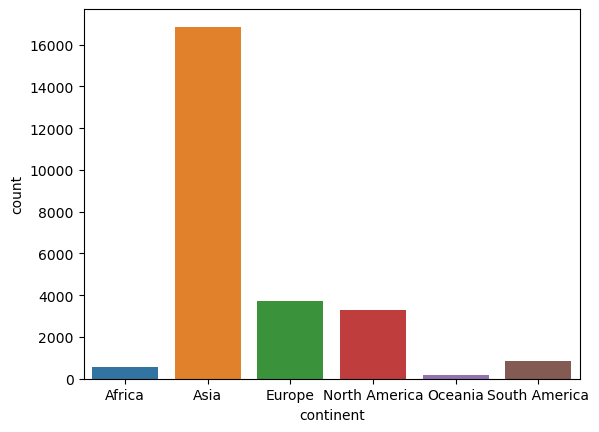

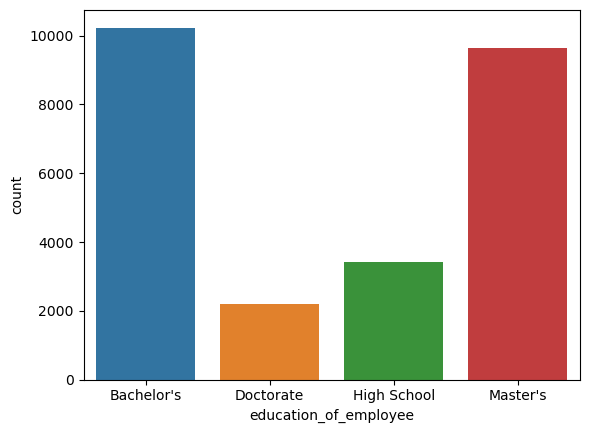

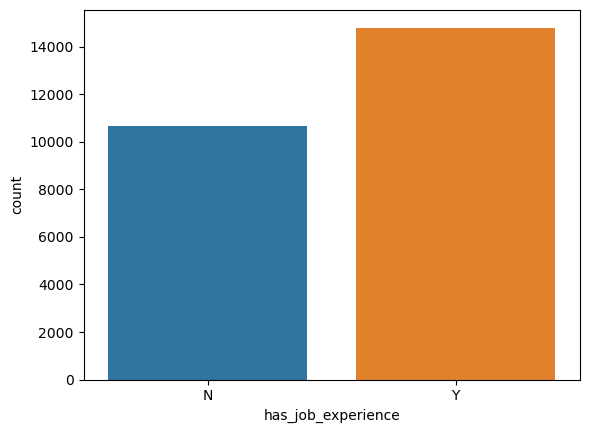

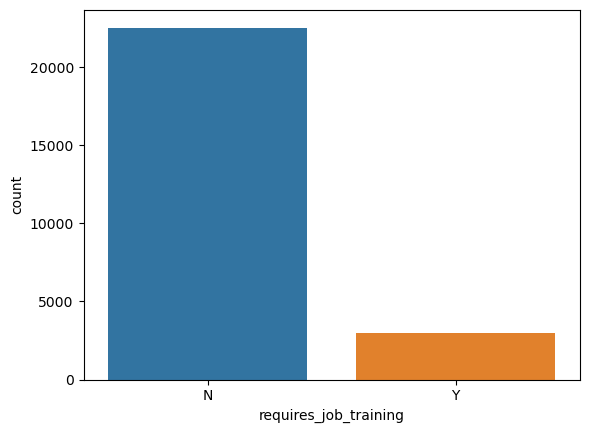

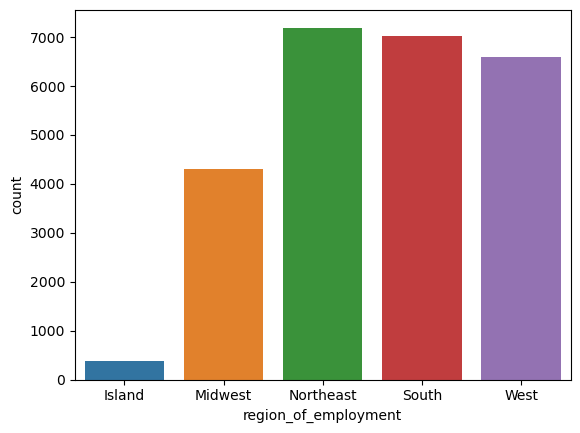

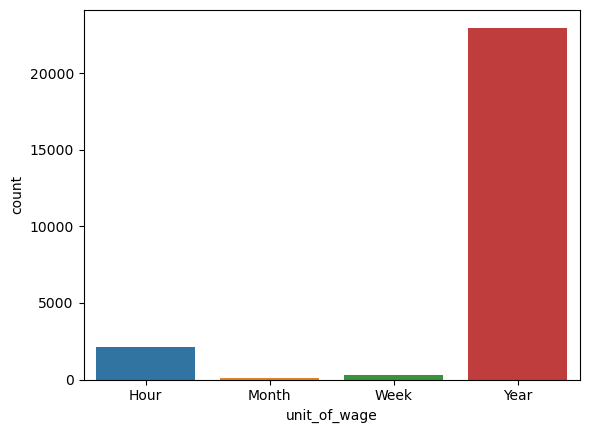

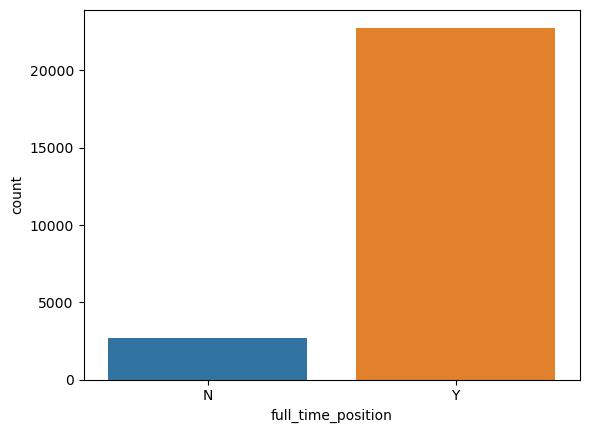

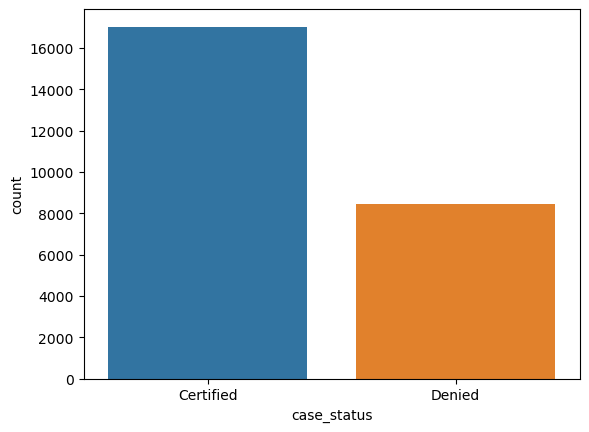

In [22]:
for col in df.columns[df.dtypes=='category']:
    sns.countplot(x=col, data=df),
    plt.show()

Observations from Univariate analysis of the categorical data
1. Most number of applicants for the visa are from Asia.
2. Most applicants have bachelors or Master's degree followed by other having high school education. least number of applicants have doctorate.
3. Most of the applicants do have job experience.
4. Most applicants do not need any job training.
5. North_east, south and west serve as the most popular regions of employement in the respective order.
6. Unit of wage popular is annual followed by hourly.
7. Most applicantions are for full time positions.
8. Approximately double the applications are certified than denied.

In [23]:
#Univariate analysis of integer dtypes

In [24]:
#provide summary statistics of all float64 variables
df.describe(include = ['int64']).T

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.0,5667.043210,22877.928848,-26.0,1022.0,2109.0,3504.0,602069.0
yr_of_estab,25480.0,1979.409929,42.366929,1800.0,1976.0,1997.0,2005.0,2016.0


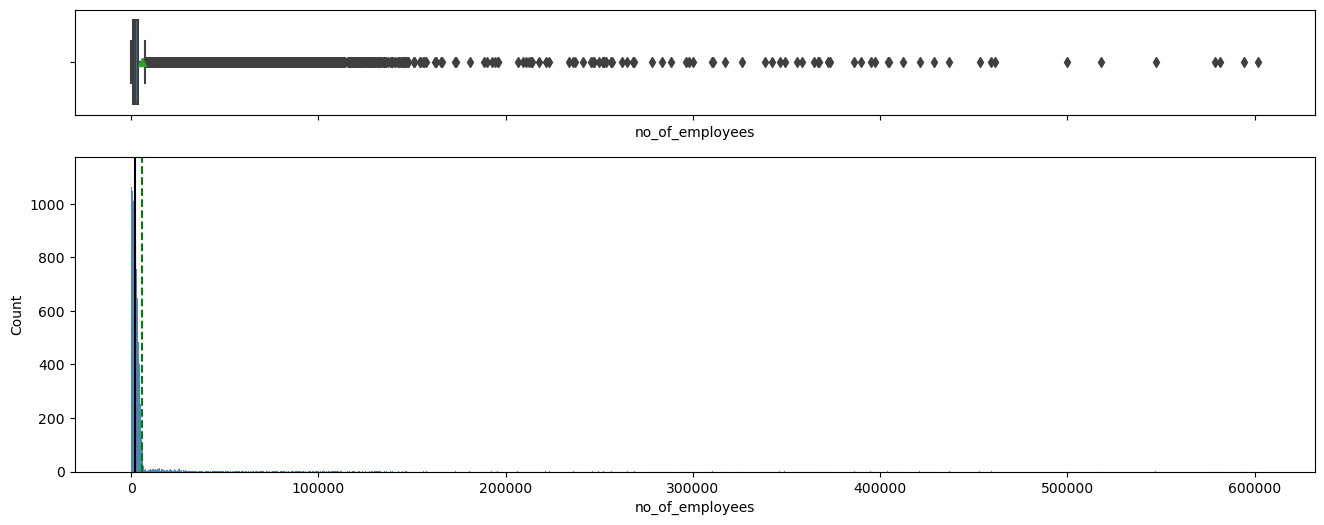

In [25]:
#provide histogram and boxplots
histogram_boxplot(df, 'no_of_employees')

The data and graphs above, indicate the distribution of companies by number of employee is heavily right skewed, but without any outlier values that require further investigation or treatment.

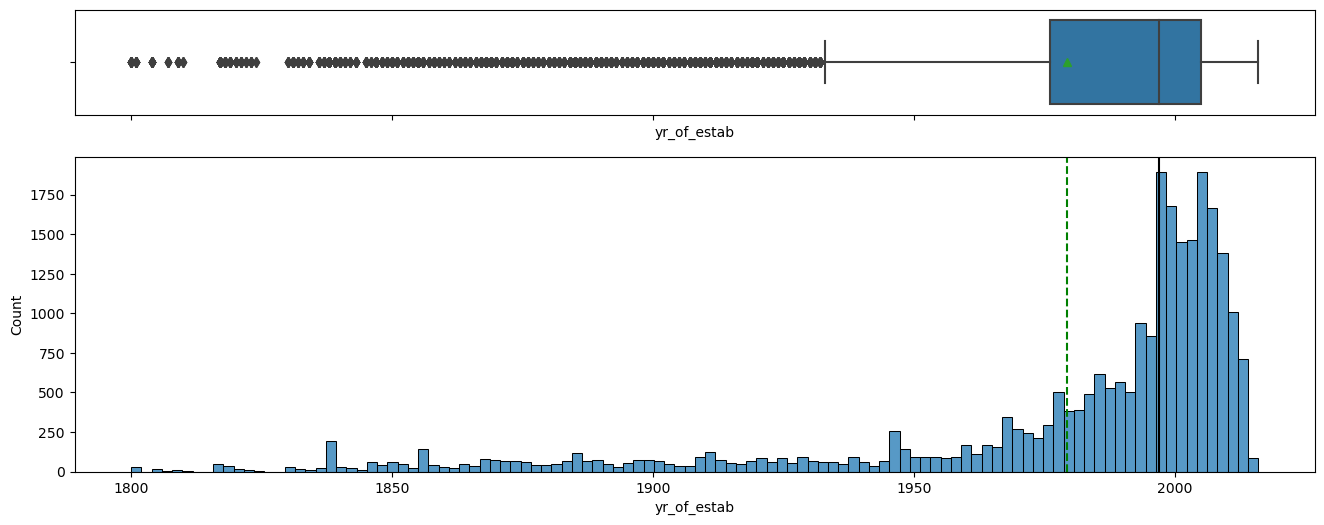

In [26]:
#provide histogram and boxplots
histogram_boxplot(df, 'yr_of_estab')

The data and graphs above, indicate the distribution of companies by year of establishment (i.e., founding) is heavily left skewed, but without any outlier values which require further investigation or treatment.


Outliers are present but without any need for treatment.

In [28]:
#Bivariate ANalysis

In [29]:
#group data by education_of_employee and count the numbers of each case_status for each category
df.groupby('education_of_employee')['case_status'].value_counts()

education_of_employee  case_status
Bachelor's             Certified      6367
                       Denied         3867
Doctorate              Certified      1912
                       Denied          280
High School            Denied         2256
                       Certified      1164
Master's               Certified      7575
                       Denied         2059
Name: case_status, dtype: int64

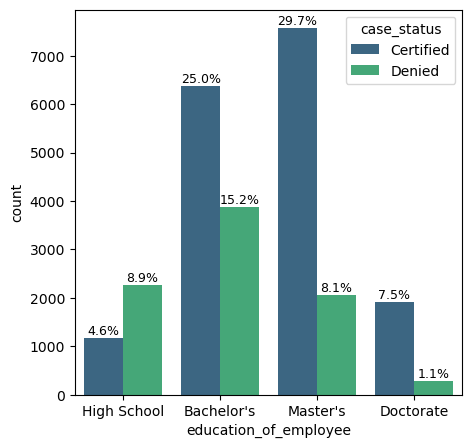

In [30]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df,'education_of_employee','case_status', order=["High School","Bachelor's","Master's","Doctorate"], perc=True)

As the graph aboves shows, the ratio of applications being certified versus denied increases considerably as an applicant's highest level of education achieved increases.
The ratio of an applicant with a high school diploma being approved versus denied is ~1:2, whereas the same ratio for an applicant with a doctorate is ~7:1.

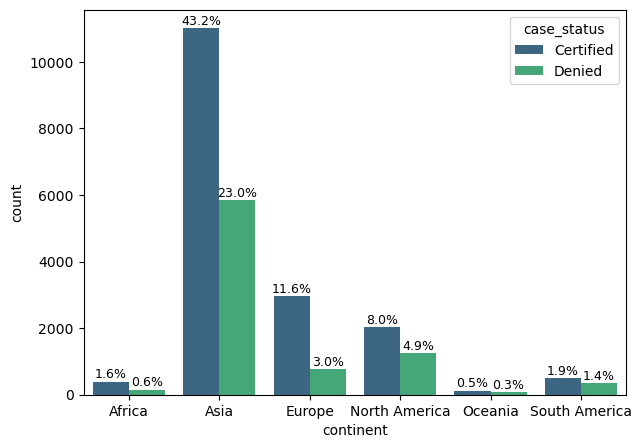

In [31]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df,'continent','case_status', order=None, perc=True)

Applicants from Asia comprise (2/3) of all applications and these applicants have almost a 2:1 ratio of approvals to denials.
An application from a European applicant has the best ratio of approvals to denials (~4:1).

In [32]:
#Now lets see if experience has any impact on the status of the visa application
df.groupby('has_job_experience')['case_status'].value_counts()

has_job_experience  case_status
N                   Certified       5994
                    Denied          4684
Y                   Certified      11024
                    Denied          3778
Name: case_status, dtype: int64

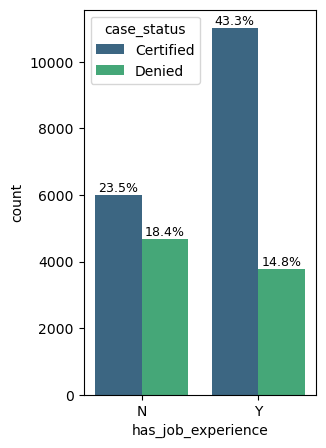

In [33]:
#create a plot of the data above, but additionally with the percent of each group within the total number of cases
labeled_barplot(df,'has_job_experience','case_status', order=None, perc=True)

Applicants with job experience have a ratio of approved to denied applications of ~3:1, whereas the same ratio for applicants without job experience have around a 5:4 ratio (i.e., approximately equivalent).

In [34]:
#group data by unit_of_wage and count the numbers of each case_status for each category
df.groupby('unit_of_wage')['case_status'].value_counts()

unit_of_wage  case_status
Hour          Denied          1410
              Certified        747
Month         Certified         55
              Denied            34
Week          Certified        169
              Denied           103
Year          Certified      16047
              Denied          6915
Name: case_status, dtype: int64

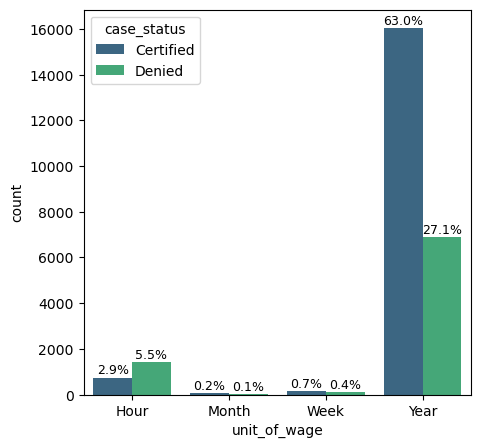

In [35]:
labeled_barplot(df,'unit_of_wage','case_status', order=None, perc=True)

Applicants who are applying to work in a job with an hourly rate have a ratio of approved versus denied applications of ~1:2. Additionally, these applicants comprise only ~8% of all applications, but comprise ~17% of all denials.
Applicants from any other unit_of_wage category have a ratio of ~2:1, with applications for jobs with annual salaries showing nearly a 2.5:1 ratio of approvals to denials.

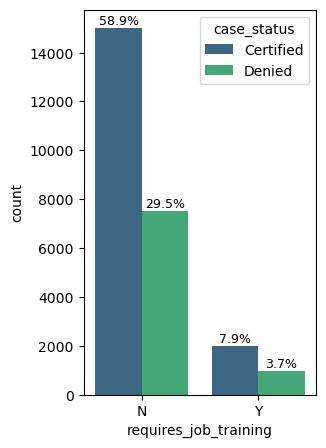

In [36]:
labeled_barplot(df,'requires_job_training','case_status', order=None, perc=True)

#Most number of applicants are the ones which do not require the on the job training whereas it seems like the ratio of approval to denail in their case is approx 2:1 where as for those who require the job training is approx 3:1

In [37]:
#Before proceeding lets do some of the data preprocessing here
df[df.no_of_employees<0].shape

(33, 11)

In [38]:
#drop the rows with errors shown above and check the remaining number of rows
df = df[df.no_of_employees>0]
df.shape

(25447, 11)

In [39]:
#group data by unit_of_wage and calculate the mean prevailing_wage for each category
df.groupby('unit_of_wage')['prevailing_wage'].mean()

unit_of_wage
Hour       414.773882
Month    87592.864045
Week     85606.820515
Year     81237.541122
Name: prevailing_wage, dtype: float64

The data shows that the unit_of_wage 'Hour' is a per-day amount, whearas the other three unit_of_wage categories are an annual salary amount.

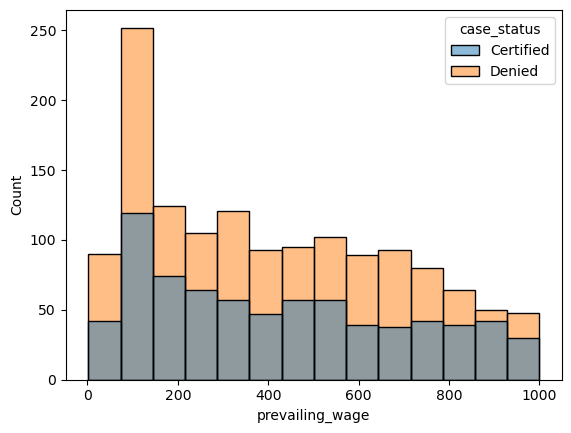

In [40]:
#create a dataframe only of workers applying for jobs with a *unit_wage* of 'Hour'
df_hourly = df[df.unit_of_wage=='Hour']
#show a distribution of the *prevailing_wage* within this dataframe, along with the ratio of *case_status* within each bin
sns.histplot(data=df_hourly, x='prevailing_wage', hue='case_status')
plt.show()

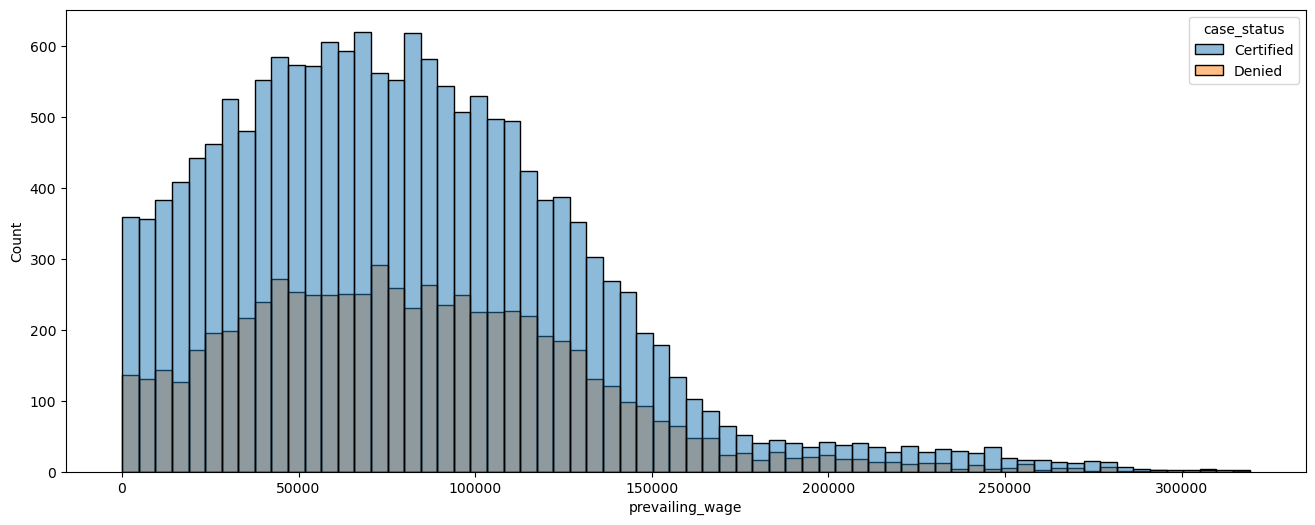

In [41]:
#create a new dataframe of only those applicants applying for jobs with annual salaries (i.e., not 'Hour')
df_annual = df[df.unit_of_wage != "Hour"]
#show the distribution of annual salaries, along with ratio of *case_status* within each bin
plt.figure(figsize=(16,6))
sns.histplot(data=df_annual, x='prevailing_wage', hue='case_status')
plt.show()

The distribution of wages is (as expected) right skewed, indicating a long-tail of jobs with annual salaries above 150,000 dollars.
As the distribution above shows, the ratio of approved to denied applications remains approximately equivalent across the range of wages.

The data and graphs above, indicate the distribution of companies by number of employee is heavily right skewed, but without any outlier values that require further investigation or treatment.

continent    Africa   Asia  Europe  North America  Oceania  South America  \
case_status                                                                 
All             550  16840    3727           3287      192            851   
Certified       396  11001    2953           2037      122            492   
Denied          154   5839     774           1250       70            359   

continent      All  
case_status         
All          25447  
Certified    17001  
Denied        8446  
------------------------------------------------------------------------------------------------------------------------


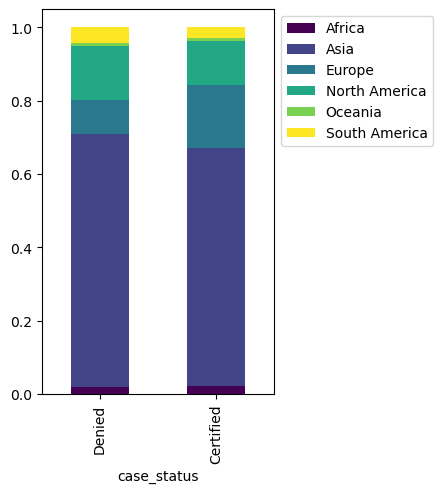

education_of_employee  Bachelor's  Doctorate  High School  Master's    All
case_status                                                               
All                         10220       2189         3416      9622  25447
Certified                    6362       1910         1164      7565  17001
Denied                       3858        279         2252      2057   8446
------------------------------------------------------------------------------------------------------------------------


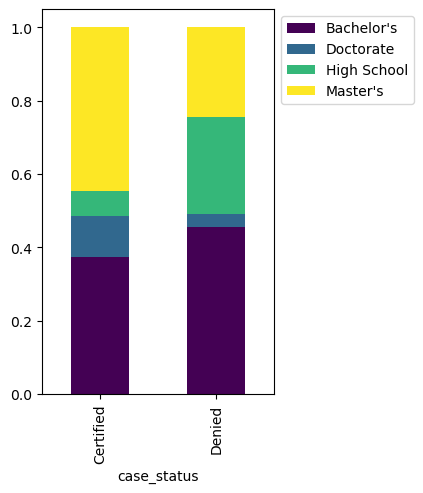

has_job_experience      N      Y    All
case_status                            
All                 10661  14786  25447
Certified            5986  11015  17001
Denied               4675   3771   8446
------------------------------------------------------------------------------------------------------------------------


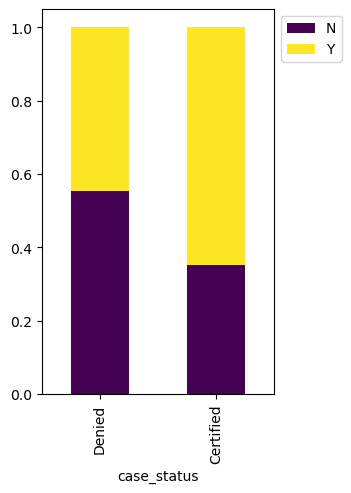

requires_job_training      N     Y    All
case_status                              
All                    22498  2949  25447
Certified              15000  2001  17001
Denied                  7498   948   8446
------------------------------------------------------------------------------------------------------------------------


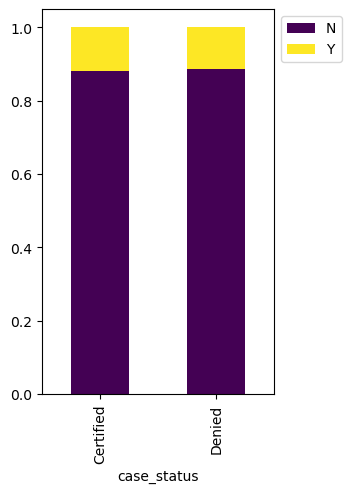

region_of_employment  Island  Midwest  Northeast  South  West    All
case_status                                                         
All                      375     4299       7189   7006  6578  25447
Certified                226     3246       4524   4908  4097  17001
Denied                   149     1053       2665   2098  2481   8446
------------------------------------------------------------------------------------------------------------------------


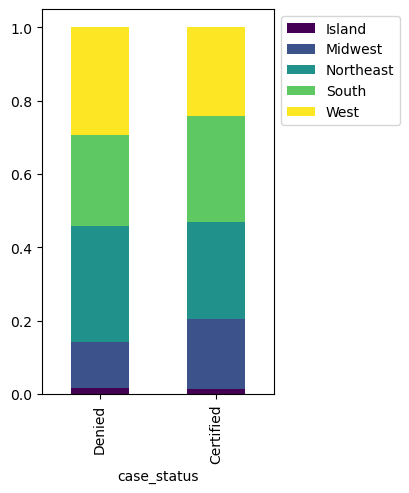

unit_of_wage  Hour  Month  Week   Year    All
case_status                                  
All           2153     89   272  22933  25447
Certified      747     55   169  16030  17001
Denied        1406     34   103   6903   8446
------------------------------------------------------------------------------------------------------------------------


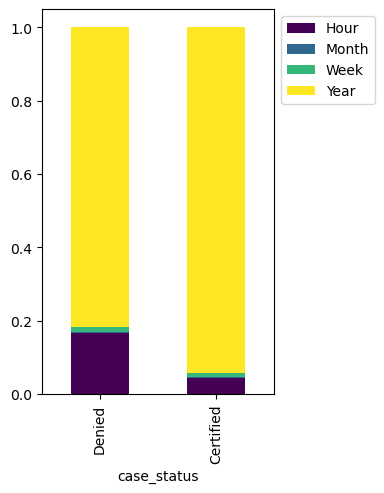

full_time_position     N      Y    All
case_status                           
All                 2706  22741  25447
Certified           1855  15146  17001
Denied               851   7595   8446
------------------------------------------------------------------------------------------------------------------------


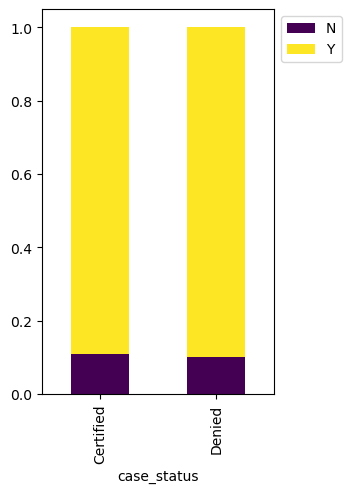

case_status  Certified  Denied    All
case_status                          
Denied               0    8446   8446
All              17001    8446  25447
Certified        17001       0  17001
------------------------------------------------------------------------------------------------------------------------


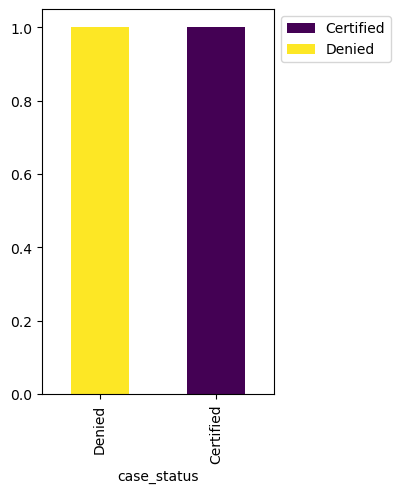

In [42]:
#create a table and stacked barplot for each variable with a data type of category by case_status
cols_cat = df.select_dtypes(['category'])
for i in cols_cat.columns:
    stacked_barplot(df, "case_status", i)

Additional EDA observations
In addition to the analysis above on the ratio of approved to denied applications by education, previous job experience, continent, prevailing wage, and unit of wage:  
If a job does or does not require training does not affect this ratio.
If a job is a full-time position or not does not affect this ratio.
If a job is located in the Midwest or South region, applicants have a higher ratio of approvals than those in the Northeast, West, and particularly the Island region.
Jobs that applicants with doctorate degree are applying for jobs have the lowest mean prevailing wage of any education.
Temporary (i.e., not full-time) jobs that applicants are applying for have a significantly higher prevailing wage than full-time positions.

## Data Preprocessing

Preparing data for modeling  
Splitting the data

In [43]:
#create bins to categorize companies by the number of years since the company was founded
bins = [0,1966,1986,1996,2006,np.Inf]
names = ['50+','30-50','20-30','10-20','0-10']
#assign each applicant to a category which indicates how long the company has been in business (i.e., a proxy for how well-established the company is)
df['company_age'] = pd.cut(df['yr_of_estab'], bins, labels=names)
df.company_age.value_counts()

10-20    8367
50+      5106
0-10     4849
30-50    3739
20-30    3386
Name: company_age, dtype: int64

In [44]:
#drop the int_64 columns from the dataframe, since this information is captured through the features engineered above
df_model = df.drop(labels=['yr_of_estab'], axis=1, inplace=True)

In [45]:
df_copy= df.copy()

In [46]:
df['case_status']

0           Denied
1        Certified
2           Denied
3           Denied
4        Certified
           ...    
25475    Certified
25476    Certified
25477    Certified
25478    Certified
25479    Certified
Name: case_status, Length: 25447, dtype: category
Categories (2, object): ['Certified', 'Denied']

Encoding Certified as 1 and Denied as 0, as the OFLC wants to identify those visa applicants who are predicted to be approved.

In [47]:
df['case_status'] = df['case_status'].apply(lambda x: 1 if x == 'Certified' else 0)

## Spliting the data

In [48]:
#We will use 70% of data for training and 30% for testing.

In [49]:
#create a dataframe of the predictor feature columns
X = df.drop('case_status',axis=1)
#create a datafrane of the predicted class (1=True, 0=False)
Y = df['case_status']

#generate dummy variables for each categorical variable
X = pd.get_dummies(X, drop_first=True)

#split the data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [50]:
Y.value_counts()

1    17001
0     8446
Name: case_status, dtype: int64

In [51]:
print(y_train.shape, y_test.shape)

(17812,) (7635,)


In [52]:
y_train.value_counts()

1    11877
0     5935
Name: case_status, dtype: int64

In [53]:
#confirm the split
print("{0:0.2f}% data is in training set".format((len(x_train)/len(df.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(x_test)/len(df.index)) * 100))

70.00% data is in training set
30.00% data is in test set


In [54]:
#confirm the shape of both data sets and the ratio of classes is the same across both train and test datasets
print("Shape of Training set : ", x_train.shape)
print("Shape of test set : ", x_test.shape)
print(' ')
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print(' ')
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (17812, 24)
Shape of test set :  (7635, 24)
 
Percentage of classes in training set:
1    0.666798
0    0.333202
Name: case_status, dtype: float64
 
Percentage of classes in test set:
1    0.67112
0    0.32888
Name: case_status, dtype: float64


## Bagging and Boosting models

Defining functions to provide metric scores (i.e., accuracy, recall, and precision) on the train and test datasets and to show the resulting confusion matrices.

In [55]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [56]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    

## Decision Tree Model

We will build our model using the DecisionTreeClassifier function, using default 'gini' criteria to split.


In [57]:
dtree = DecisionTreeClassifier(criterion='gini', random_state=1, class_weight='balanced')

In [58]:
dtree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=1)

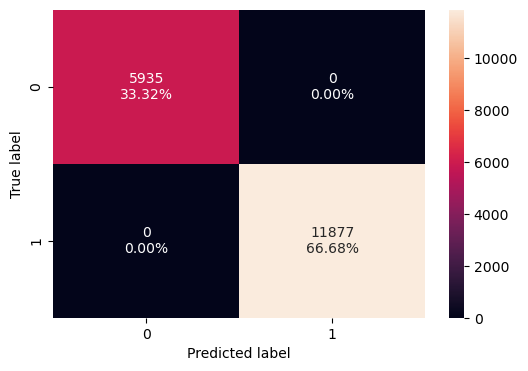

In [59]:
confusion_matrix_sklearn(dtree, x_train, y_train)

In [60]:
dtree_model_train_perf=model_performance_classification_sklearn(dtree, x_train, y_train)
print("Training performance \n",dtree_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


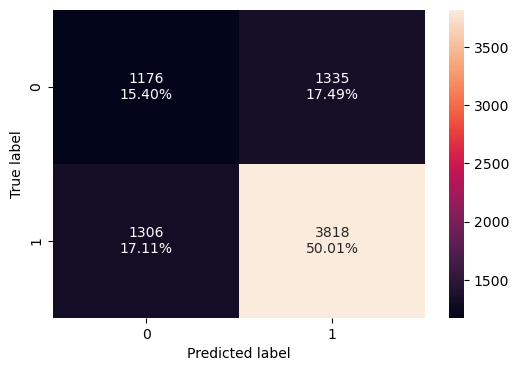

In [61]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(dtree, x_test, y_test)

In [62]:
dtree_model_test_perf=model_performance_classification_sklearn(dtree, x_test, y_test)
print("Testing performance \n",dtree_model_test_perf)

Testing performance 
    Accuracy    Recall  Precision        F1
0  0.654093  0.745121   0.740928  0.743018


In [63]:
# Model is very overfit and next we will go to the first technique of bagging.

In [64]:
# Bagging Classifier

In [65]:
bagging = BaggingClassifier(random_state=1)
bagging.fit(x_train,y_train)

BaggingClassifier(random_state=1)

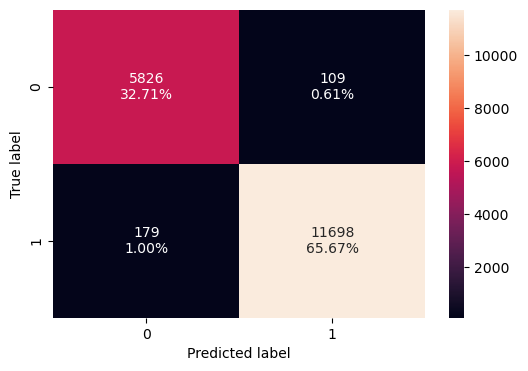

In [66]:
confusion_matrix_sklearn(bagging, x_train, y_train)

In [67]:
bagging_model_train_perf=model_performance_classification_sklearn(bagging, x_train, y_train)
print("Training performance \n",bagging_model_train_perf)

Training performance 
    Accuracy    Recall  Precision       F1
0  0.983831  0.984929   0.990768  0.98784


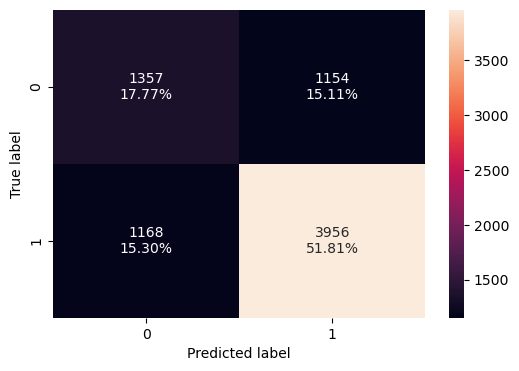

In [68]:
confusion_matrix_sklearn(bagging, x_test, y_test)

In [69]:
bagging_model_test_perf=model_performance_classification_sklearn(bagging, x_test, y_test)
print("Training performance \n",bagging_model_test_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.695874  0.772053   0.774168  0.773109


Similar to the Decision Tree model, this bagging classifer is overfit to the training dataset but has a higher F1 score.


## Random Forest

In [70]:
rf = RandomForestClassifier(random_state=1)
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=1)

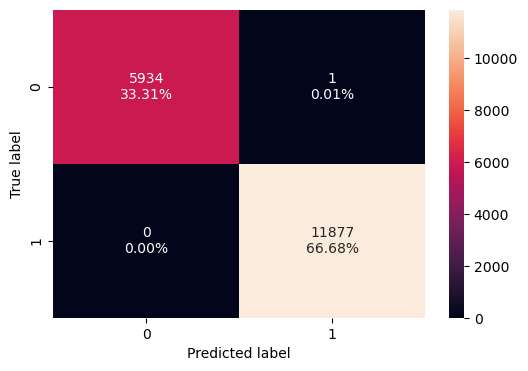

In [71]:
#create a confusion matrix of the classifier's performance on the training data
confusion_matrix_sklearn(rf,x_train,y_train)

In [72]:
rf_model_train_perf=model_performance_classification_sklearn(rf,x_train,y_train)
print("Training performance \n",rf_model_train_perf)

Training performance 
    Accuracy  Recall  Precision        F1
0  0.999944     1.0   0.999916  0.999958


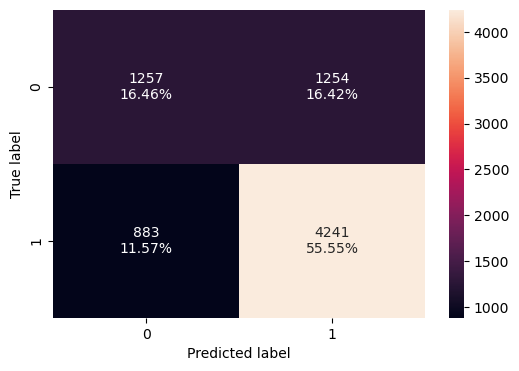

In [73]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(rf,x_test,y_test)

In [74]:
rf_model_test_perf=model_performance_classification_sklearn(rf,x_test,y_test)
print("Training performance \n",rf_model_test_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.720105  0.827674   0.771793  0.798757


Similar to the models above, this Random Forest is also overfit to the training dataset but has the highest F1 score so far.


## AdaBoost Classifier

In [75]:
ab_classifier=AdaBoostClassifier(random_state=1)
ab_classifier.fit(x_train,y_train)

AdaBoostClassifier(random_state=1)

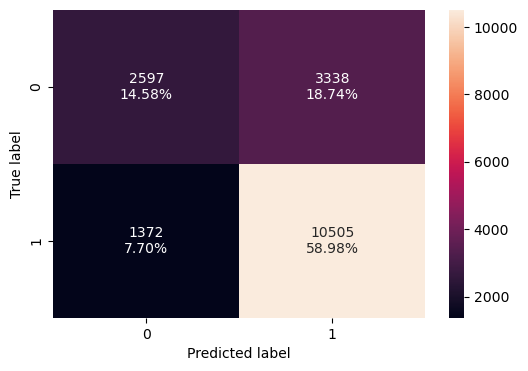

In [76]:
#create a confusion matrix of the classifier's performance on the training data
confusion_matrix_sklearn(ab_classifier, x_train,y_train)

In [77]:
ab_classifier_model_train_perf = model_performance_classification_sklearn(ab_classifier,x_train,y_train)
print("Training performance \n",ab_classifier_model_train_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.735572  0.884483   0.758867  0.816874


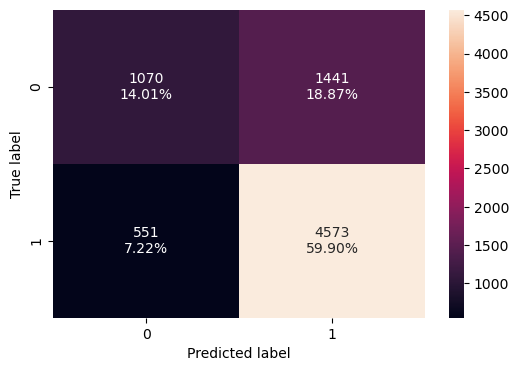

In [78]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(ab_classifier, x_test,y_test)

In [79]:
ab_classifier_model_test_perf = model_performance_classification_sklearn(ab_classifier,x_test,y_test)
print("Training performance \n",ab_classifier_model_test_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.739096  0.892467   0.760392  0.821153


This AdaBoost classifer performs equally well on the training and testing datasets, indicating that the model is not overfit.
Additionally, the model performs the best of any model yet (i.e., highest F1 score) on the testing data.

## Gradient Boosting Classifier

In [80]:
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(x_train,y_train)

GradientBoostingClassifier(random_state=1)

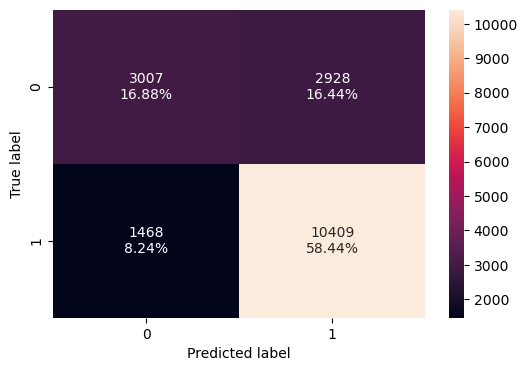

In [81]:
#create a confusion matrix of the classifier's performance on the training data
confusion_matrix_sklearn(gbc, x_train,y_train)

In [82]:
gbc_classifier_model_train_perf = model_performance_classification_sklearn(gbc,x_train,y_train)
print("Training performance \n",gbc_classifier_model_train_perf)

Training performance 
    Accuracy  Recall  Precision        F1
0    0.7532  0.8764    0.78046  0.825652


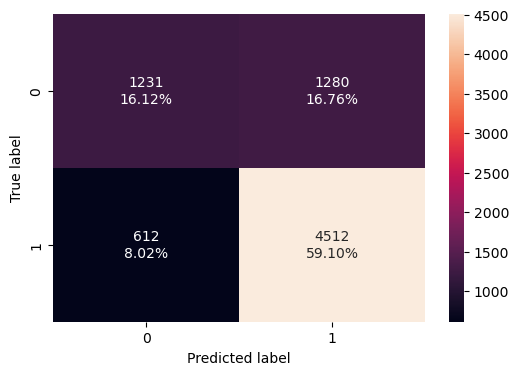

In [83]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(gbc, x_test,y_test)

In [84]:
gbc_classifier_model_test_perf = model_performance_classification_sklearn(gbc,x_test,y_test)
print("Training performance \n",gbc_classifier_model_test_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.752194  0.880562   0.779006  0.826676


This Gradient Boosting classifer performs equally well on the training and testing datasets, indicating that the model is not overfit.
Additionally, this model performs even better than the AdaBoost model above.

## XGBoost Classifier

In [85]:
xgb = XGBClassifier(random_state=1,eval_metric='logloss')
xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

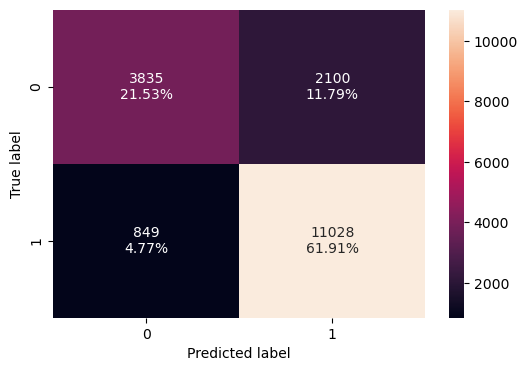

In [86]:
#create a confusion matrix of the classifier's performance on the training data
confusion_matrix_sklearn(xgb, x_train,y_train)

In [87]:
xgb_classifier_model_train_perf = model_performance_classification_sklearn(xgb,x_train,y_train)
print("Training performance \n",xgb_classifier_model_train_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.834437  0.928517   0.840037  0.882064


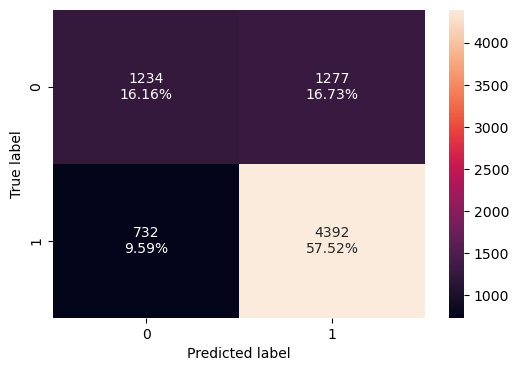

In [88]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(xgb, x_test,y_test)

In [89]:
xgb_classifier_model_test_perf = model_performance_classification_sklearn(xgb,x_test,y_test)
print("Training performance \n",xgb_classifier_model_test_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0   0.73687  0.857143    0.77474  0.813861


This XGBoost classifer performs equally well on the training and testing datasets, indicating that the model is not overfit.
Additionally, this model performs as well as the AdaBoost model and slightly worse the Gradient Boost model on the test data.

## Base models comparison

In [90]:
# create a dataframe comparing the performance of the base models on the training data

models_train_comp_df = pd.concat(
    [dtree_model_train_perf.T,
     bagging_model_train_perf.T,
     rf_model_train_perf.T,
     ab_classifier_model_train_perf.T, 
     gbc_classifier_model_train_perf.T, 
     xgb_classifier_model_train_perf.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Bagging Classifier",
    "Random Forest",
    "AdaBoost Classifier",
    "Gradient Boosting Classifier",
    "XGBoost Classifier"]
print("Training performance comparison of base models:")
models_train_comp_df

Training performance comparison of base models:


,Decision Tree,Bagging Classifier,Random Forest,AdaBoost Classifier,Gradient Boosting Classifier,XGBoost Classifier
Accuracy,1.0,0.983831,0.999944,0.735572,0.753200,0.834437
Recall,1.0,0.984929,1.000000,0.884483,0.876400,0.928517
Precision,1.0,0.990768,0.999916,0.758867,0.780460,0.840037
F1,1.0,0.987840,0.999958,0.816874,0.825652,0.882064


In [91]:
# create a dataframe comparing the performance of the base models on the testing data

models_test_comp_df = pd.concat(
    [dtree_model_test_perf.T,
     bagging_model_test_perf.T,
     rf_model_test_perf.T,
     ab_classifier_model_test_perf.T, 
     gbc_classifier_model_test_perf.T, 
     xgb_classifier_model_test_perf.T],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree",
    "Bagging Classifier",
    "Random Forest",
    "AdaBoost Classifier",
    "Gradient Boosting Classifier",
    "XGBoost Classifier"]
print("Testing performance comparison of base models:")
models_test_comp_df

Testing performance comparison of base models:


,Decision Tree,Bagging Classifier,Random Forest,AdaBoost Classifier,Gradient Boosting Classifier,XGBoost Classifier
Accuracy,0.654093,0.695874,0.720105,0.739096,0.752194,0.736870
Recall,0.745121,0.772053,0.827674,0.892467,0.880562,0.857143
Precision,0.740928,0.774168,0.771793,0.760392,0.779006,0.774740
F1,0.743018,0.773109,0.798757,0.821153,0.826676,0.813861


Overall, the bagging models perform best on the training data, due to all three of the models overfitting this data set.
As shown above, all three of the boosting models do not overfit the data and achieve higher F1 scores on the training data set, with the Gradient Boosting classifier performing the best.

## Hyperparameter tuning

Tuning Decision Tree

In [92]:
# Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(5,30,5),
              'min_samples_leaf': [3, 5, 7],
              'max_leaf_nodes' : [2, 4, 6],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_estimator.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=4,
                       min_impurity_decrease=0.0001, min_samples_leaf=3,
                       random_state=1)

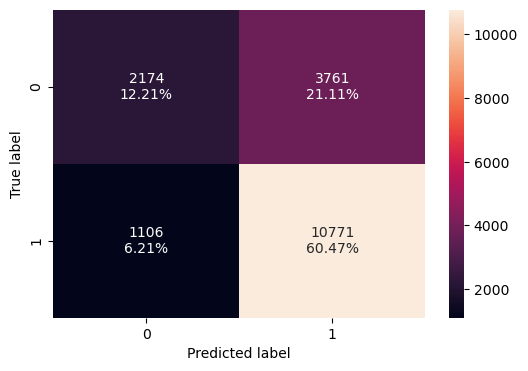

In [93]:
#create a confusion matrix of the classifier's performance on the training data
confusion_matrix_sklearn(dtree_estimator, x_train,y_train)

In [94]:
dtree_estimator_model_train_perf=model_performance_classification_sklearn(dtree_estimator, x_train,y_train)
print("Training performance \n",dtree_estimator_model_train_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.726757  0.906879   0.741192  0.815707


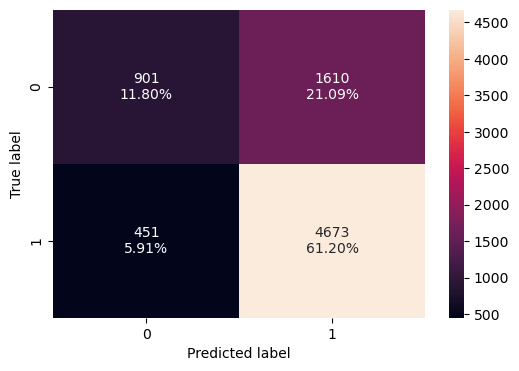

In [95]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(dtree_estimator, x_test,y_test)

In [96]:
dtree_estimator_model_test_perf=model_performance_classification_sklearn(dtree_estimator, x_test, y_test)
print("Testing performance \n",dtree_estimator_model_test_perf)

Testing performance 
    Accuracy    Recall  Precision        F1
0  0.730059  0.911983   0.743753  0.819321


The Decision Tree model after tuning performs equally well on the training and testing datasets, indicating that the model is not overfit.
Additionally, this model performs as well as two out of the three boosting models above on the test data.
Both of these indicate this tuned model is a significant improvements over the base mode

## Tuning Bagging Classifier



In [97]:
# random search for bagging classifier
parameters = {'max_samples': [0.7,0.8,0.9,1],
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : np.arange(50, 100, 10)
             }

#run the randomized search
rand_bag = RandomizedSearchCV(BaggingClassifier(random_state=1,bootstrap=True), 
                              parameters, scoring = 'f1', cv = 5, random_state=1)
rand_bag = rand_bag.fit(x_train, y_train)

# Set the clf to the best combination of parameters
bag_tuned = rand_bag.best_estimator_

# Fit the best algorithm to the data
bag_tuned.fit(x_train, y_train)

BaggingClassifier(max_features=0.8, max_samples=0.8, n_estimators=70,
                  random_state=1)

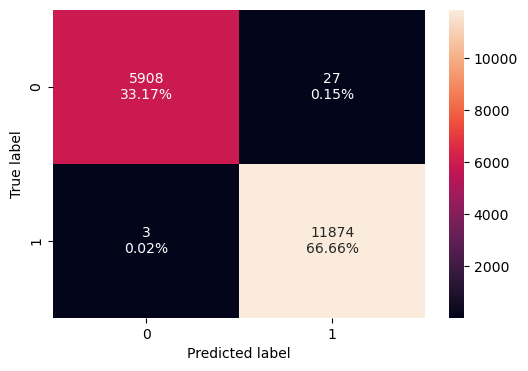

In [99]:
#create a confusion matrix of the classifier's performance on the training data
confusion_matrix_sklearn(bag_tuned, x_train,y_train)

In [100]:
bagging_estimator_model_train_perf=model_performance_classification_sklearn(bag_tuned, x_train,y_train)
print("Training performance \n",bagging_estimator_model_train_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.998316  0.999747   0.997731  0.998738


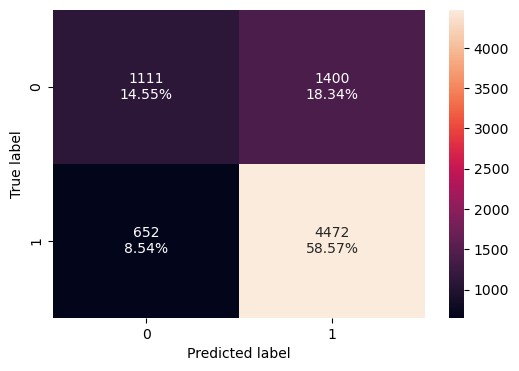

In [101]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(bag_tuned, x_test,y_test)

In [102]:
bagging_estimator_model_test_perf=model_performance_classification_sklearn(bag_tuned, x_test, y_test)
print("Testing performance \n",bagging_estimator_model_test_perf)

Testing performance 
    Accuracy    Recall  Precision        F1
0  0.731238  0.872756    0.76158  0.813387


The Bagging Classifier after tuning performs far less well on the test data than on the training data, indicating that the model is still overfit.
However, this model does perform better than the base model.

## Tuning Random Forest



In [103]:
# Choose the type of classifier. 
rf_estimator = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {"n_estimators": np.arange(10, 40, 10),
              "min_samples_leaf": np.arange(5, 10),
              "min_samples_split": [3, 5, 7],
              "max_features": ["sqrt", "log2"],
              "max_samples": np.arange(0.3, 0.7, 0.1),
}

# Run the randomized search
rand_rf = RandomizedSearchCV(rf_estimator, parameters, scoring='f1', cv=5, n_jobs=-1, random_state=1)
rand_rf = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator = rand_rf.best_estimator_

# Fit the best algorithm to the data. 
rf_estimator.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=4,
                       min_impurity_decrease=0.0001, min_samples_leaf=3,
                       random_state=1)

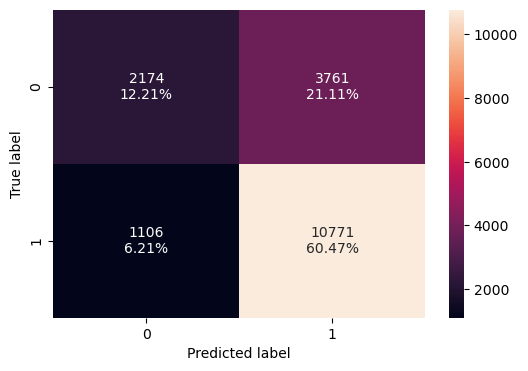

In [104]:
#create a confusion matrix of the classifier's performance on the training data
confusion_matrix_sklearn(rf_estimator, x_train,y_train)

In [105]:
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator, x_train,y_train)
print("Training performance \n",rf_estimator_model_train_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.726757  0.906879   0.741192  0.815707


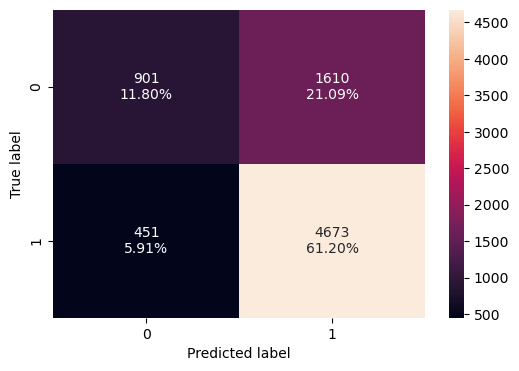

In [106]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(rf_estimator, x_test,y_test)

In [107]:
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator, x_test, y_test)
print("Testing performance \n",rf_estimator_model_test_perf)

Testing performance 
    Accuracy    Recall  Precision        F1
0  0.730059  0.911983   0.743753  0.819321


The Random Forest after tuning performs equally well on the training and testing datasets, indicating that the model is not overfit.
Additionally, this model performs as well as two out of the three boosting models and the tuned Decision Tree on the test data.
Both of these indicate this tuned model is a significant improvements over the base model.

## Tuning AdaBoost Classifier

In [108]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1, random_state=1, class_weight='balanced'),
                      DecisionTreeClassifier(max_depth=2, random_state=1, class_weight='balanced'),
                      DecisionTreeClassifier(max_depth=3, random_state=1, class_weight='balanced')],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the randomized search
rand_abc = RandomizedSearchCV(abc_tuned, parameters, scoring=acc_scorer,cv=5, n_jobs=-1, random_state=1)
rand_abc = rand_abc.fit(x_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = rand_abc.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=1,
                                                         random_state=1),
                   learning_rate=0.5, n_estimators=20, random_state=1)

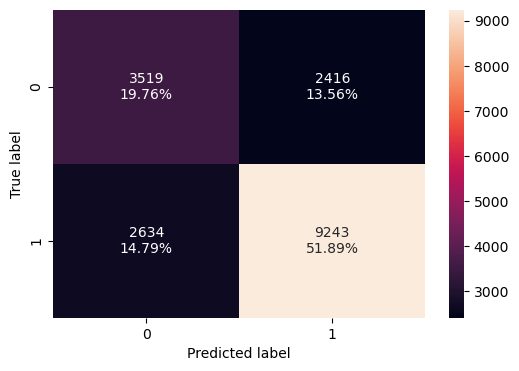

In [109]:
#create a confusion matrix of the classifier's performance on the training data
confusion_matrix_sklearn(abc_tuned, x_train,y_train)

In [110]:
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned, x_train,y_train)
print("Training performance \n",abc_tuned_model_train_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.716483  0.778227   0.792778  0.785435


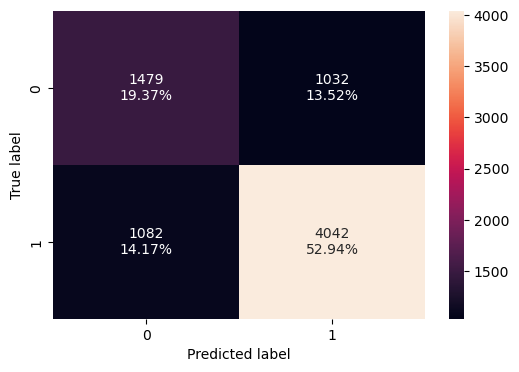

In [111]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(abc_tuned, x_test,y_test)

In [112]:
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned, x_test, y_test)
print("Testing performance \n",abc_tuned_model_test_perf)

Testing performance 
    Accuracy    Recall  Precision        F1
0  0.723117  0.788837    0.79661  0.792704


The AdaBoost classifier after tuning performs equally well on the training and testing datasets, indicating that the model is not overfit.
However, this model performs worse than the base model on both the train and test data.

## Tuning GradientBoost Classifier

In [114]:
#Choose the type of classifier. 
gb_tuned = GradientBoostingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {"n_estimators": [150,200,250,300],
              "subsample":[0.8,0.9,1],
              "max_features":[0.7,0.8,0.9,1],
              "learning_rate": np.arange(0.1, 0.4, 0.1)}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the randomized search
rand_gb = RandomizedSearchCV(gb_tuned, parameters, scoring=scorer,cv=5, n_jobs=-1, random_state=1)
rand_gb = rand_gb.fit(x_train, y_train)

# Set the clf to the best combination of parameters
gb_tuned = rand_gb.best_estimator_

# Fit the best algorithm to the data. 
gb_tuned.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.4, max_features=1, n_estimators=150,
                           random_state=1, subsample=1)

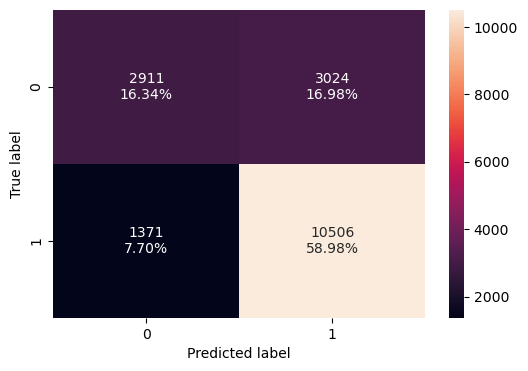

In [115]:
#create a confusion matrix of the classifier's performance on the training data
confusion_matrix_sklearn(gb_tuned, x_train,y_train)

In [116]:
gb_tuned_model_train_perf=model_performance_classification_sklearn(rf_estimator, x_train,y_train)
print("Training performance \n",gb_tuned_model_train_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.726757  0.906879   0.741192  0.815707


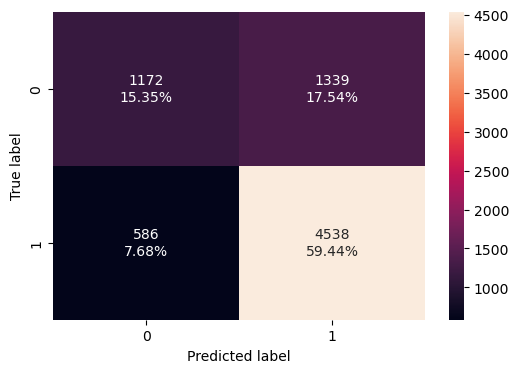

In [117]:
#create a confusion matrix of the classifier's performance on the testing data
confusion_matrix_sklearn(gb_tuned, x_test,y_test)

In [118]:
gb_tuned_model_test_perf=model_performance_classification_sklearn(rf_estimator, x_test, y_test)
print("Testing performance \n",gb_tuned_model_test_perf)

Testing performance 
    Accuracy    Recall  Precision        F1
0  0.730059  0.911983   0.743753  0.819321


The Gradient Boosting classifier after tuning performs equally well on the training and testing datasets, indicating that the model is not overfit.
However, this model performs slightly worse than the base model on both the train and test data

In [119]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {"n_estimators": np.arange(10,100,20),
              "scale_pos_weight":[0,1,2,5],
              "subsample":[0.5,0.7,0.9,1],
              "learning_rate":[0.01,0.1,0.2,0.05],
              "gamma":[0,1,3],
              "colsample_bytree":[0.5,0.7,0.9,1],
              "colsample_bylevel":[0.5,0.7,0.9,1]}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the randomized search
rand_xgb = RandomizedSearchCV(xgb_tuned, parameters, scoring=scorer,cv=5, n_jobs=-1, random_state=1)
rand_xgb = rand_xgb.fit(x_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = rand_xgb.best_estimator_

# Fit the best algorithm to the data. 
xgb_tuned.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=0.7,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=3,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=90, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

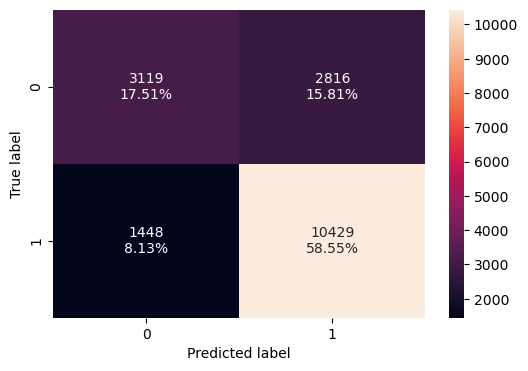

In [120]:
confusion_matrix_sklearn(xgb_tuned, x_train,y_train)

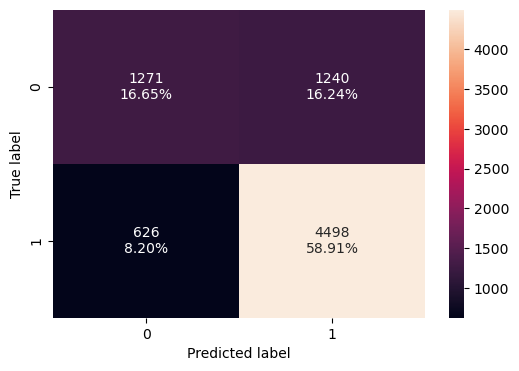

In [121]:
confusion_matrix_sklearn(xgb_tuned, x_test,y_test)

In [122]:
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned, x_train,y_train)
print("Training performance \n",xgb_tuned_model_train_perf)

Training performance 
    Accuracy    Recall  Precision        F1
0  0.760611  0.878084   0.787391  0.830268


In [123]:
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned, x_test, y_test)
print("Testing performance \n",xgb_tuned_model_test_perf)

Testing performance 
    Accuracy   Recall  Precision        F1
0  0.755599  0.87783   0.783897  0.828208


The XGBoost classifier after tuning is less overfit than the base model, but performs equally well on the test data.
This indicates a minor improvement over the base model.

## Tuned models comparison

In [124]:
# create a dataframe comparing the performance of the tuned models on the training data

tuned_models_train_comp_df = pd.concat(
    [dtree_estimator_model_train_perf.T,
     bagging_estimator_model_train_perf.T,
     rf_estimator_model_train_perf.T,
     abc_tuned_model_train_perf.T, 
     gb_tuned_model_train_perf.T, 
     xgb_tuned_model_train_perf.T],
    axis=1,
)
tuned_models_train_comp_df.columns = [
    "Tuned Decision Tree",
    "Tuned Bagging Classifier",
    "Tuned Random Forest",
    "Tuned AdaBoost Classifier",
    "Tuned Gradient Boosting Classifier",
    "Tuned XGBoost Classifier"]
print("Training performance comparison of tuned models:")
tuned_models_train_comp_df

Training performance comparison of tuned models:


,Tuned Decision Tree,Tuned Bagging Classifier,Tuned Random Forest,Tuned AdaBoost Classifier,Tuned Gradient Boosting Classifier,Tuned XGBoost Classifier
Accuracy,0.726757,0.998316,0.726757,0.716483,0.726757,0.760611
Recall,0.906879,0.999747,0.906879,0.778227,0.906879,0.878084
Precision,0.741192,0.997731,0.741192,0.792778,0.741192,0.787391
F1,0.815707,0.998738,0.815707,0.785435,0.815707,0.830268


In [125]:
# create a dataframe comparing the performance of the tuned models on the testing data

tuned_models_test_comp_df = pd.concat(
    [dtree_estimator_model_test_perf.T,
     bagging_estimator_model_test_perf.T,
     rf_estimator_model_test_perf.T,
     abc_tuned_model_test_perf.T, 
     gb_tuned_model_test_perf.T, 
     xgb_tuned_model_test_perf.T],
    axis=1,
)
tuned_models_test_comp_df.columns = [
    "Tuned Decision Tree",
    "Tuned Bagging Classifier",
    "Tuned Random Forest",
    "Tuned AdaBoost Classifier",
    "Tuned Gradient Boosting Classifier",
    "Tuned XGBoost Classifier"]
print("Testing performance comparison of tuned models:")
tuned_models_test_comp_df

Testing performance comparison of tuned models:


,Tuned Decision Tree,Tuned Bagging Classifier,Tuned Random Forest,Tuned AdaBoost Classifier,Tuned Gradient Boosting Classifier,Tuned XGBoost Classifier
Accuracy,0.730059,0.731238,0.730059,0.723117,0.730059,0.755599
Recall,0.911983,0.872756,0.911983,0.788837,0.911983,0.877830
Precision,0.743753,0.761580,0.743753,0.796610,0.743753,0.783897
F1,0.819321,0.813387,0.819321,0.792704,0.819321,0.828208


## Model Performance Comparison

In [126]:
# create a dataframe comparing the performance all models on the training data
all_models_train_comp = pd.concat([models_train_comp_df,tuned_models_train_comp_df],axis=1)
all_models_train_comp.T.sort_values('F1',ascending=False)

,Accuracy,Recall,Precision,F1
Decision Tree,1.000000,1.000000,1.000000,1.000000
Random Forest,0.999944,1.000000,0.999916,0.999958
Tuned Bagging Classifier,0.998316,0.999747,0.997731,0.998738
Bagging Classifier,0.983831,0.984929,0.990768,0.987840
XGBoost Classifier,0.834437,0.928517,0.840037,0.882064
Tuned XGBoost Classifier,0.760611,0.878084,0.787391,0.830268
Gradient Boosting Classifier,0.753200,0.876400,0.780460,0.825652
AdaBoost Classifier,0.735572,0.884483,0.758867,0.816874
Tuned Decision Tree,0.726757,0.906879,0.741192,0.815707
Tuned Random Forest,0.726757,0.906879,0.741192,0.815707


In [127]:
'The best performing model on the training data is the ' + all_models_train_comp.T.sort_values('F1',ascending=False).index[0]


'The best performing model on the training data is the Decision Tree'

In [128]:
# create a dataframe comparing the performance of all models on the testing data
all_models_test_comp = pd.concat([models_test_comp_df,tuned_models_test_comp_df],axis=1)
all_models_test_comp.T.sort_values('F1',ascending=False)

,Accuracy,Recall,Precision,F1
Tuned XGBoost Classifier,0.755599,0.877830,0.783897,0.828208
Gradient Boosting Classifier,0.752194,0.880562,0.779006,0.826676
AdaBoost Classifier,0.739096,0.892467,0.760392,0.821153
Tuned Decision Tree,0.730059,0.911983,0.743753,0.819321
Tuned Random Forest,0.730059,0.911983,0.743753,0.819321
Tuned Gradient Boosting Classifier,0.730059,0.911983,0.743753,0.819321
XGBoost Classifier,0.736870,0.857143,0.774740,0.813861
Tuned Bagging Classifier,0.731238,0.872756,0.761580,0.813387
Random Forest,0.720105,0.827674,0.771793,0.798757
Tuned AdaBoost Classifier,0.723117,0.788837,0.796610,0.792704


In [129]:
'The best performing model on the testing data is the ' + all_models_test_comp.T.sort_values('F1',ascending=False).index[0]


'The best performing model on the testing data is the Tuned XGBoost Classifier'

Observations
As expected the Decision Tree model performs the best on the training dataset, since the model will significantly overfit this data unless pruned otherwise.  

The base Gradient Boosting classifier performs the best on the testing dataset, with an 0.83 F1 score.  

Interestingly, six models tied for the second-best performance, with an F1 score of 0.82.

## Feature importance of: Gradient Boosting Classifier

In [130]:
"""The importance of features in the tree building 
(The importance of a feature is computed as the (normalized) total 
reduction of the criterion brought by that feature.)"""

print(pd.DataFrame(gbc.feature_importances_, columns = ["Imp"], 
                   index = x_train.columns).sort_values(by = 'Imp', ascending = False).head(10))

                                        Imp
education_of_employee_High School  0.288945
has_job_experience_Y               0.166291
prevailing_wage                    0.106758
education_of_employee_Master's     0.086262
education_of_employee_Doctorate    0.085220
unit_of_wage_Year                  0.062710
continent_Europe                   0.058783
region_of_employment_Midwest       0.030800
no_of_employees                    0.021106
continent_North America            0.018117


In [131]:
feature_names = x_train.columns

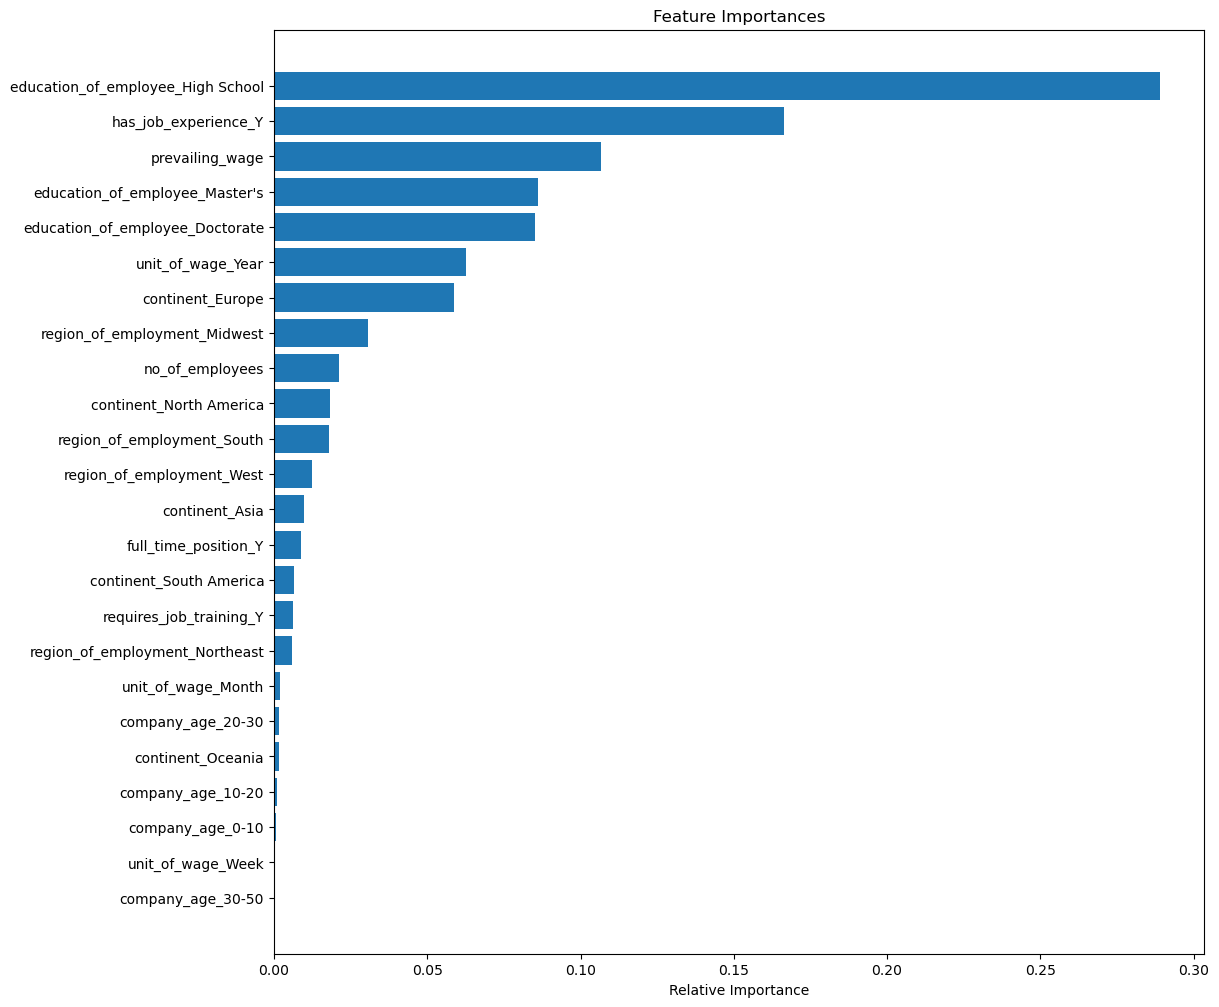

In [132]:
importances = gbc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Conclusions

Insights
For the Office of Foreign Labor Certification (OFLC), the three most critical components for pre-screening an applicant are:

Education level  
An applicant applying for a job requiring a high school diploma will more than likely be denied. Conversely, applications for jobs requiring a Master's degree or doctorate are very likely to be approved.  

Prior job experience  
An applicant applying for a job without any previous job experience is more likley to be denied than an applicant for a job with experience.  

Prevailing wage  
The higher the prevailing wage of the job an applicant is applying for, the more likely the application will be approved. This is especially true for applications for jobs with an hourly unit of wage.

## Recommendations

To prioritize limited resources towards screening a batch of applications for those most likely to be approved, the OFLC can:  
Sort applications by level of education and review the higher levels of education first.  
Sort applications by previous job experience and review those with experience first.  
Divide applications for jobs into those with an hourly wage and those with an annual wage, sort each group by the prevailing wage, then review applications for salaried jobs first from highest to lowest wage.  
As stated previously, the Gradient Boosting classifier performs the best of all the models created. However, as shown above, the tuned Decision-Tree model performs barely worse by F1 score and is a far simpler model. This model may be preferable if post-hoc explanations of OFLC decision-making is expected to be required.  

For those in less skilled, entry-level, and/or hourly jobs, the system would appear to be biased against these applications being certified.